# Bike Montreal data science (Daily user predicton)

**Diclaimer**: If anyone is reading this, please note that this project is my first data science project. It is my first time using Jupyter notebooks, pandas, SQL and many other things. I have also deliberately decided to not follow a similar project as an example because I feared I would simply copy the work and not learn as much in consequence.  This means that this project will **not** follow best practices in the industry or even correct usage of tools and libraries. My goal was to blindly jump into a project and learn as I go.

## Objective

[Bixi](https://bixi.com/en) is Montreal's public bike share program. It has been in service since 2014 and now has close to 800 stations with close to 10000 bikes in the network. In a previous project where I first learned Python and webscrapping, I scrapped Bixi's open data since 2014 and the historical daily weather of Montreal. In this project, I will attempt to predict the daily usage of Bixi bikes based on the different trends and weather condition.

## Sections (TODO)

In [297]:
import helpers
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

BIXI_TABLE_ID = 'bixi-montreal.bixi.all-rides'
WEATHER_TABLE_ID = 'bixi-montreal.bixi.mtl-weather'



## Creating our dataframe

Let's query from **gbq** the first and last day of bixi and weather data and see if there is any weather data missing.

In [176]:
first_day_bixi = helpers.get_min_value(BIXI_TABLE_ID, 'start_date')
last_day_bixi = helpers.get_max_value(BIXI_TABLE_ID, 'start_date')
first_day_weather = helpers.get_min_value(WEATHER_TABLE_ID, 'DATE')
last_day_weather = helpers.get_max_value(WEATHER_TABLE_ID, 'DATE')

enough_min = first_day_weather <= first_day_bixi
enough_max = last_day_weather >= last_day_bixi

if enough_min != True and enough_max != True:
  print(f'Need weather data since {first_day_bixi} and until {last_day_bixi}')
elif enough_min != True:
  print(f'Need weather data since {first_day_bixi}')
elif enough_max != True:
  print(f'Need weather data until {last_day_bixi}')
else:
  print('You have all the weather data you needed!')

You have all the weather data you needed!


Create our main dataframe called main_df

In [177]:
# create empty dataframe
main_df = pd.DataFrame(columns=('DATE', 'DAILY_COUNT', 'MEAN_TEMP', 'TOTAL_RAIN', 'TOTAL_SNOW'))


In [178]:
first_day_bixi = helpers.get_min_value(BIXI_TABLE_ID, 'start_date')
last_day_bixi = helpers.get_max_value(BIXI_TABLE_ID, 'start_date')

start_date = datetime.date(first_day_bixi.year, first_day_bixi.month, first_day_bixi.day)
end_date = datetime.date(last_day_bixi.year, last_day_bixi.month, last_day_bixi.day)

daily_weather_df = helpers.get_weather_data(start_date, end_date)

In [179]:
# Loop through each day and concat date, daily bixi count, all weather variables to the main dataframe.
increment_date = start_date

while(end_date >= increment_date):
  temp_daily_weather_df = daily_weather_df.loc[pd.to_datetime(daily_weather_df['DATE']).dt.date == increment_date]
  daily_count = helpers.get_daily_count(increment_date)['f0_'][0] 
  temp_df =  pd.DataFrame(data = {
  'DATE': [increment_date], 
  'DAILY_COUNT': [daily_count], 
  'MEAN_TEMP': [temp_daily_weather_df['MEAN_TEMP'].iloc[0]],
  'TOTAL_RAIN': [temp_daily_weather_df['TOTAL_RAIN'].iloc[0]],
  'TOTAL_SNOW': [temp_daily_weather_df['TOTAL_SNOW'].iloc[0]],
  })

  main_df = pd.concat([main_df, temp_df])
  print(main_df.tail(1))
  increment_date += relativedelta(days=1)

print(main_df.shape)

So it took exactly 60 minutes to create the dataset. Let's create a csv file to prevent redoing this.

In [6]:
# Export the dataframe as csv

# REMOVE THIS AT THE END!!!
# main_df.to_csv('main-bixi-data.csv', index = False, header=True)

main_df = pd.read_csv('main-bixi-data.csv')

## Light data exploration 

In [55]:
# have an idea of how the data looks like
main_df.head(5)

,DATE,DAILY_COUNT,MEAN_TEMP,TOTAL_RAIN,TOTAL_SNOW
0,2014-04-15,1577,5.6,8.6,0.4
1,2014-04-16,3180,-3.4,0.0,0.0
2,2014-04-17,5852,2.4,0.0,0.0
3,2014-04-18,5325,6.3,0.0,0.0
4,2014-04-19,6031,5.1,0.4,0.0


In [8]:
# How many rows and columns?
main_df.shape

(2969, 5)

In [9]:
# What types are each of the columns?
main_df.dtypes

DATE            object
DAILY_COUNT      int64
MEAN_TEMP      float64
TOTAL_RAIN     float64
TOTAL_SNOW     float64
dtype: object

In [10]:
# How many NAN do I have per column?
main_df.isna().sum()

DATE            0
DAILY_COUNT     0
MEAN_TEMP      12
TOTAL_RAIN     25
TOTAL_SNOW     11
dtype: int64

**Findings** 
- There are 3058 days of data.
- I saved the daily count as an object instead of an int for some reason... 😅
- Both DATE and DAILY_COUNT columns have no missing data. 
- MEAN_TEMP has 12 NAN values, TOTAL_RAIN has 15 NAN values and TOTAL_SNOW has 11 NAN. (Considering we have 3058 days of data, it's not too bad).

## Data cleaning

Some amount of cleaning was done during the webscrapping. In retrospect, I am thinking that it would have been better practice to scrape the *dirty* data as is and clean it all at one place... This being said, here are the issues I need to fix:

- Clone the main_df and do all cleaning on this one. That way I won't loose the original dataframe.
- Convert the DAILY_COUNT column to an int
- Replace the NAN values int the different columns.

In [11]:
# Clone the main_df to keep it intact for the rest of the project
main_df_cleaned = main_df

In [12]:
# Convert DAILY_COUNT column to int.
main_df_cleaned = main_df_cleaned.astype({'DAILY_COUNT': 'int32'})


In [13]:
# fill NAN with previous values using the backfill method (Should be an ok solution since we are talking about a handful of data points in more than 3000 days of data) 
main_df_cleaned = main_df_cleaned.fillna(method = 'backfill')

In [14]:
main_df_cleaned.to_csv('cleaned-main-bixi-data.csv', index = False, header=True)

## Data exploration

- plot temp, rain, snow with Daily rides
- plot month with daily rides
- plot day of week (Monday to Sunday) vs rides
- plot year vs rides 

Let's remove all rows with 0 as DAILY_COUNT value. These are the days where Bixi is ot in service (Winter months in Canada). Keeping them in certain plots makes no sense...

In [102]:
# removing rows with DAILY_COUNT equal to 0.
main_df_cleaned_active = main_df_cleaned[main_df_cleaned['DAILY_COUNT'] != 0]
main_df_cleaned_active = main_df_cleaned_active.reset_index(drop=True)
main_df_cleaned_active

,DATE,DAILY_COUNT,MEAN_TEMP,TOTAL_RAIN,TOTAL_SNOW
0,2014-04-15,1577,5.6,8.6,0.4
1,2014-04-16,3180,-3.4,0.0,0.0
2,2014-04-17,5852,2.4,0.0,0.0
3,2014-04-18,5325,6.3,0.0,0.0
4,2014-04-19,6031,5.1,0.4,0.0
...,...,...,...,...,...
1762,2022-05-27,26532,19.1,31.2,0.0
1763,2022-05-28,47495,18.1,1.0,0.0
1764,2022-05-29,52075,19.4,0.0,0.0
1765,2022-05-30,43544,21.5,0.0,0.0


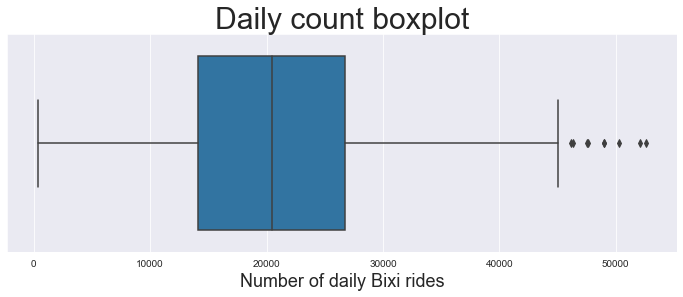

In [208]:
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = 12,4

count_boxplot = sns.boxplot(x=main_df_cleaned_active['DAILY_COUNT'])
count_boxplot.set_title('Daily count boxplot', fontsize= 30)
count_boxplot.set_xlabel('Number of daily Bixi rides', fontsize = 18)
plt.show()

The Daily Count boxplot is quite symetric other than a few outliers to the right. The 2nd and 3rd quartile are noticably smaller than the 1rst and 4rth. So we can say tht 50% of the days, there is between 14000 and 26000 daily rides.


In [209]:
main_df_cleaned_active['DAILY_COUNT'].describe()

count     1767.000000
mean     20724.680249
std       9016.793032
min        334.000000
25%      14086.000000
50%      20489.000000
75%      26707.000000
max      52630.000000
Name: DAILY_COUNT, dtype: float64

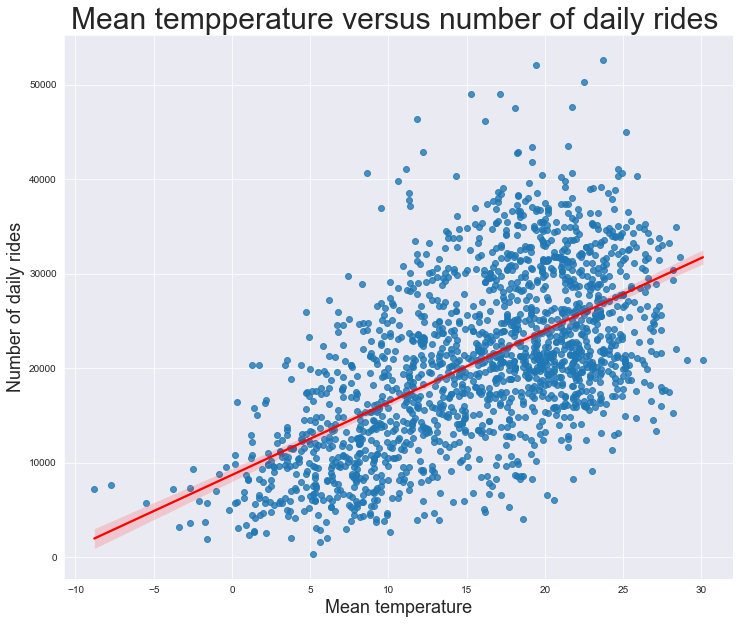

In [213]:
temp_scatter = sns.regplot(data=main_df_cleaned_active, x="MEAN_TEMP", y="DAILY_COUNT", line_kws={"color": "red"})
plt.rcParams['figure.figsize'] = 12,10
temp_scatter.set_title('Mean tempperature versus number of daily rides ', fontsize= 30)
temp_scatter.set_xlabel('Mean temperature', fontsize = 18)
temp_scatter.set_ylabel('Number of daily rides', fontsize = 18)

plt.show()


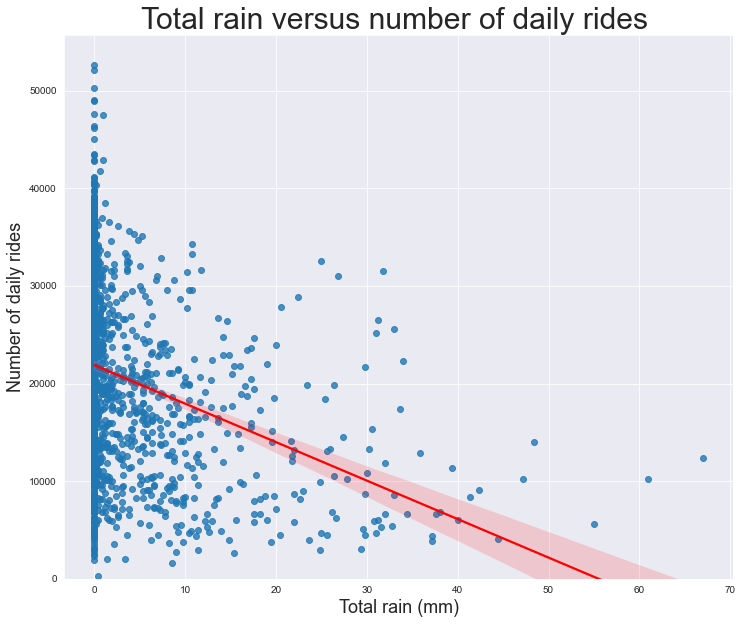

In [268]:
rain_dist = sns.regplot(data=main_df_cleaned_active, x="TOTAL_RAIN", y="DAILY_COUNT", line_kws={"color": "red"})
plt.rcParams['figure.figsize'] = 12,10
rain_dist.set_title('Total rain versus number of daily rides ', fontsize= 30)
rain_dist.set_xlabel('Total rain (mm)', fontsize = 18)
rain_dist.set_ylabel('Number of daily rides', fontsize = 18)
rain_dist.set(ylim=(0, None))
plt.show()

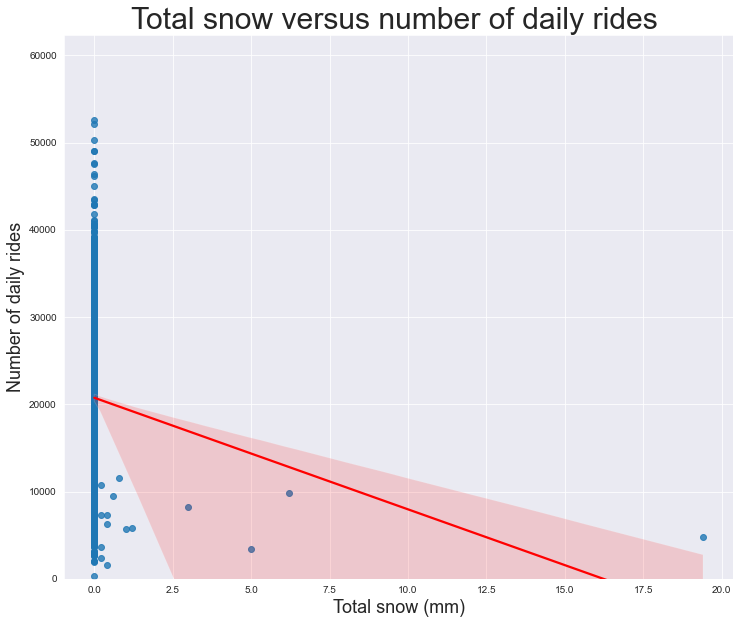

In [269]:
rain_dist = sns.regplot(data=main_df_cleaned_active, x="TOTAL_SNOW", y="DAILY_COUNT", line_kws={"color": "red"})
plt.rcParams['figure.figsize'] = 12,10
rain_dist.set_title('Total snow versus number of daily rides ', fontsize= 30)
rain_dist.set_xlabel('Total snow (mm)', fontsize = 18)
rain_dist.set_ylabel('Number of daily rides', fontsize = 18)
rain_dist.set(ylim=(0, None))
plt.show()

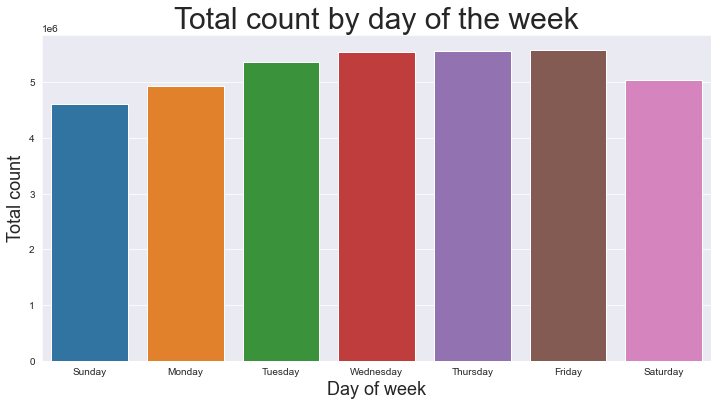

In [179]:
main_df_cleaned_active_day = main_df_cleaned_active.copy()
main_df_cleaned_active_day = main_df_cleaned_active_day.drop(columns=['MEAN_TEMP', 'TOTAL_RAIN', 'TOTAL_SNOW'])
main_df_cleaned_active_day.rename(columns = {'DATE':'DAY', 'DAILY_COUNT':'TOTAL_COUNT'}, inplace = True)
main_df_cleaned_active_day['DAY'] = pd.to_datetime(main_df_cleaned_active_day['DAY'])
main_df_cleaned_active_day['DAY'] = main_df_cleaned_active_day['DAY'].dt.day_name()
main_df_cleaned_active_day = main_df_cleaned_active_day.groupby(['DAY']).sum()

plt.rcParams['figure.figsize'] = 12,6
total_by_day = sns.barplot(x = main_df_cleaned_active_day.index, y = main_df_cleaned_active_day['TOTAL_COUNT'].values, order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
total_by_day.set_title('Total count by day of the week', fontsize= 30)
total_by_day.set_xlabel('Day of week', fontsize = 18)
total_by_day.set_ylabel('Total count', fontsize = 18)
plt.show()

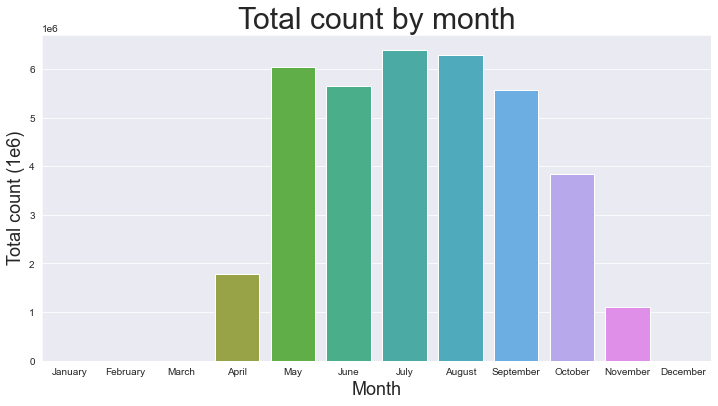

In [274]:
main_df_cleaned_month = main_df_cleaned.copy()
main_df_cleaned_month = main_df_cleaned_month.drop(columns=['MEAN_TEMP', 'TOTAL_RAIN', 'TOTAL_SNOW'])
main_df_cleaned_month.rename(columns = {'DATE':'MONTH', 'DAILY_COUNT':'TOTAL_COUNT'}, inplace = True)
main_df_cleaned_month['MONTH'] = pd.to_datetime(main_df_cleaned_month['MONTH'])
main_df_cleaned_month['MONTH'] = main_df_cleaned_month['MONTH'].dt.month_name()
main_df_cleaned_month = main_df_cleaned_month.groupby(['MONTH']).sum()
main_df_cleaned_month

plt.rcParams['figure.figsize'] = 12,6
total_by_month = sns.barplot(x = main_df_cleaned_month.index, y = main_df_cleaned_month['TOTAL_COUNT'].values, order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
total_by_month.set_title('Total count by month', fontsize= 30)
total_by_month.set_xlabel('Month', fontsize = 18)
total_by_month.set_ylabel('Total count (1e6)', fontsize = 18)
plt.show()

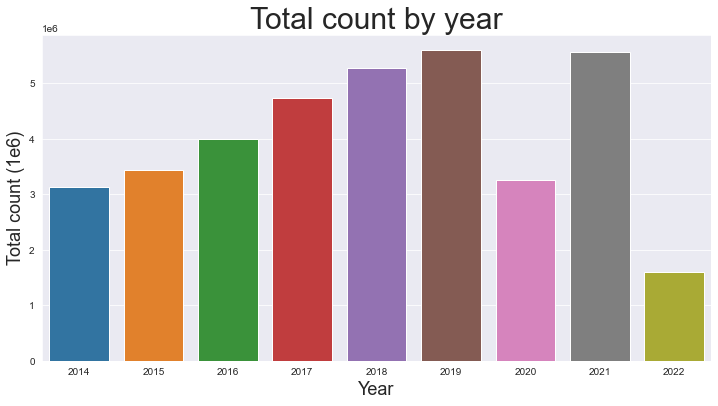

In [272]:
main_df_cleaned_year = main_df_cleaned.copy()
main_df_cleaned_year = main_df_cleaned_year.drop(columns=['MEAN_TEMP', 'TOTAL_RAIN', 'TOTAL_SNOW'])
main_df_cleaned_year.rename(columns = {'DATE':'YEAR', 'DAILY_COUNT':'TOTAL_COUNT'}, inplace = True)
main_df_cleaned_year['YEAR'] = pd.DatetimeIndex(main_df_cleaned_year['YEAR']).year
main_df_cleaned_year = main_df_cleaned_year.groupby(['YEAR']).sum()

plt.rcParams['figure.figsize'] = 12,6
total_by_year = sns.barplot(x = main_df_cleaned_year.index, y = main_df_cleaned_year['TOTAL_COUNT'].values, order=list(range(2014, 2023)))
total_by_year.set_title('Total count by year', fontsize= 30)
total_by_year.set_xlabel('Year', fontsize = 18)
total_by_year.set_ylabel('Total count (1e6)', fontsize = 18)
plt.show()

### Observations
- The daily count boxplot reveals that the datset is very symetric. The quartiles show that 50% of the daily rides throught the year is between 14000 and 26000.
- The most Bixi rides in a single day reached over 52000 rides.
- There seems to be a positive correlation between the daily weather and the total rides. That being said, there is high variance.
- There seems to be a negative correlation between the total rainfall and the total rides. 
- There is probably a negative correlation between snowfall and total rides. That being said, the dataset is highly skewed towards days with 0mm of snowfall. This is to be expected since the Bixi service is not offered during the winter months in Montreal. Therefore, there might not be enough datapoints to conclude a precise correlation.
- Days of the week were somewhat surprising. Sunday is the least popular day while Wednesday, Thursday and Friday are neck and neck for the most popular day.
- Months of the year show a bigger difference than days of the week. April and November are the least popular. That being said, Bixi's service is only offered for half of those months. December to March there are no rides since the service is not offered. Lastly, October is the least popular month the has the service running all month.
- As for year to year, there is a pretty clear increase since 2014. Because of Covid, 2020 dropped by almost 50% the previous year's usage. The year 2021 almost caught up with 2019's popularity. It is quite good considering that the province of Québec had some restrictions due to covid and work from home was heavily suggested by the provincial government.
- We are in the middle of 2022 and so data is still coming in. It seems to be back to it's pre-covid popularity.

## Model Building

To build a linear regression model, the Date column as it is will not work. I need to extract the relevant information from it like the day of week, the month and the year. We already did this in alternate dataframes in the analysis section.

In [321]:
# Let's build a df with days, months and years. 
main_test_train_df = main_df_cleaned.copy()
main_test_train_df['MONTH'] = pd.DatetimeIndex(main_test_train_df['DATE']).month
main_test_train_df['DAY'] = pd.DatetimeIndex(main_test_train_df['DATE']).day
main_test_train_df['DATE'] = pd.DatetimeIndex(main_test_train_df['DATE']).year
main_test_train_df.rename(columns = {'DATE':'YEAR'}, inplace = True)
main_test_train_df.tail()


,YEAR,DAILY_COUNT,MEAN_TEMP,TOTAL_RAIN,TOTAL_SNOW,MONTH,DAY
2964,2022,26532,19.1,31.2,0.0,5,27
2965,2022,47495,18.1,1.0,0.0,5,28
2966,2022,52075,19.4,0.0,0.0,5,29
2967,2022,43544,21.5,0.0,0.0,5,30
2968,2022,46155,16.2,0.0,0.0,5,31


In [322]:
# Y = main_test_train_df['DAILY_COUNT']
Y = pd.DataFrame(main_test_train_df['DAILY_COUNT'])
X = main_test_train_df.drop(columns=['DAILY_COUNT'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [325]:
# Ctrain our model
LR = LinearRegression()
LR.fit(X_train.values, Y_train.values)

LinearRegression()

In [329]:
# test the model
prediction = LR.predict(X_test.values)
LR.score(X_test.values, Y_test.values)

0.7092006827241017